# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [5]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [6]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for 0_W
Gradient check passed!
Checking gradient for 0_B
Gradient check passed!
Checking gradient for 2_W
Gradient check passed!
Checking gradient for 2_B
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [7]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for 0_W
Gradient check passed!
Checking gradient for 0_B
Gradient check passed!
Checking gradient for 2_W
Gradient check passed!
Checking gradient for 2_B
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [8]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [9]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 2.302029, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301685, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301851, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.302623, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302031, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301124, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302831, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301638, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302170, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302117, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302455, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302807, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302832, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302390, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303278, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301772, Train acc

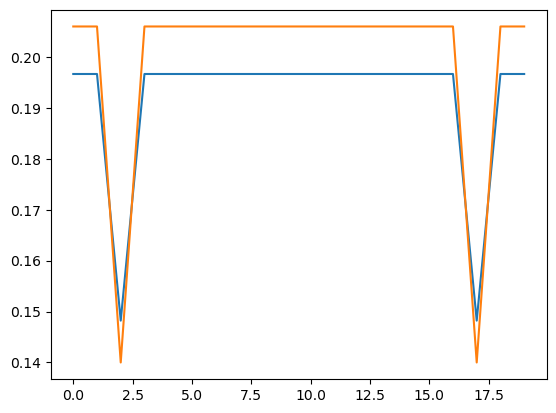

In [10]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [11]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.275985, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.347515, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.264348, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.287890, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.253264, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.265011, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.212698, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.320777, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302624, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.311032, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.234316, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.283390, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.353994, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.217454, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.378711, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.256101, Train acc

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [13]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.326953, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.326195, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.311708, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.284157, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.305318, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.284334, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.296940, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.257185, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.274806, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.307607, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.289114, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.311188, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301019, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.288091, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.227376, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.252873, Train acc

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [14]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.331328, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.310703, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.291657, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.309175, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.285151, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.349267, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.201855, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.304504, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.273527, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.144258, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.024621, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.280749, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.970813, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.956334, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.680280, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.264016, Train acc

Loss: 1.193351, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.650212, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.158934, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.335021, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.383050, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.128154, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.342809, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.344441, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.590973, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.180131, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.240281, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.489221, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.149247, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.492698, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.556331, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.438006, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [15]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 300, reg = 1e-6)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=20, batch_size=10)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.304247, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302232, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.292482, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.265006, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.305327, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.239999, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.229105, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.184533, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.075194, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 1.937369, Train accuracy: 0.266667, val accuracy: 0.133333
Loss: 1.829491, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 1.940054, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 1.371704, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.179751, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.532514, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.376065, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [16]:
# Let's train the best one-hidden-layer network we can

learning_rates = [1e-1, 1e-2, 1e-3]
reg_strength = [1e-3, 1e-5]
hidden_layer_sizes = [32, 64, 128]
num_epochs = 16
batch_size = [64, 128, 256]

best_classifier = None
best_val_accuracy = 0

loss_history = []
train_history = []
val_history = []

dataset = Dataset(train_X, train_y, val_X, val_y)

for lr in learning_rates:
    for rs in reg_strength:
        for ls in hidden_layer_sizes:
            for bs in batch_size:
                model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=ls, reg=rs)
                trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=lr, num_epochs=num_epochs, batch_size=bs)
                temp_loss_history, temp_train_history, temp_val_history = trainer.fit()
                
                if temp_val_history[-1] > best_val_accuracy:
                    best_classifier = model
                    best_val_accuracy = temp_val_history[-1]
                    loss_history = temp_loss_history.copy()
                    train_history = temp_train_history.copy()
                    val_history = temp_val_history.copy()

print('best validation accuracy achieved: %f' % best_val_accuracy)

Loss: 2.042059, Train accuracy: 0.267667, val accuracy: 0.271000
Loss: 1.710796, Train accuracy: 0.501000, val accuracy: 0.484000
Loss: 1.141269, Train accuracy: 0.565222, val accuracy: 0.590000
Loss: 1.657801, Train accuracy: 0.547889, val accuracy: 0.534000
Loss: 1.472976, Train accuracy: 0.541222, val accuracy: 0.545000
Loss: 1.644531, Train accuracy: 0.623333, val accuracy: 0.594000
Loss: 1.694556, Train accuracy: 0.596556, val accuracy: 0.584000
Loss: 1.314834, Train accuracy: 0.627556, val accuracy: 0.608000
Loss: 1.444662, Train accuracy: 0.607889, val accuracy: 0.595000
Loss: 1.740818, Train accuracy: 0.635222, val accuracy: 0.596000
Loss: 1.725274, Train accuracy: 0.652889, val accuracy: 0.633000
Loss: 1.785209, Train accuracy: 0.626444, val accuracy: 0.633000
Loss: 1.392622, Train accuracy: 0.634556, val accuracy: 0.614000
Loss: 1.135165, Train accuracy: 0.596778, val accuracy: 0.587000
Loss: 1.198030, Train accuracy: 0.633889, val accuracy: 0.623000
Loss: 1.778554, Train acc

Loss: 1.518903, Train accuracy: 0.723778, val accuracy: 0.658000
Loss: 2.282179, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.184666, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 1.878273, Train accuracy: 0.319444, val accuracy: 0.321000
Loss: 1.604997, Train accuracy: 0.469333, val accuracy: 0.457000
Loss: 1.431790, Train accuracy: 0.545000, val accuracy: 0.532000
Loss: 1.595347, Train accuracy: 0.617889, val accuracy: 0.603000
Loss: 1.357975, Train accuracy: 0.611889, val accuracy: 0.607000
Loss: 1.071019, Train accuracy: 0.686222, val accuracy: 0.661000
Loss: 0.887169, Train accuracy: 0.706556, val accuracy: 0.664000
Loss: 1.072309, Train accuracy: 0.728889, val accuracy: 0.688000
Loss: 1.251212, Train accuracy: 0.717778, val accuracy: 0.689000
Loss: 1.227131, Train accuracy: 0.753111, val accuracy: 0.702000
Loss: 1.349692, Train accuracy: 0.727000, val accuracy: 0.668000
Loss: 0.836261, Train accuracy: 0.745889, val accuracy: 0.701000
Loss: 0.975946, Train acc

Loss: 0.539980, Train accuracy: 0.742222, val accuracy: 0.658000
Loss: 1.643300, Train accuracy: 0.760667, val accuracy: 0.663000
Loss: 2.297428, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 1.697782, Train accuracy: 0.363556, val accuracy: 0.360000
Loss: 2.136599, Train accuracy: 0.562778, val accuracy: 0.564000
Loss: 0.998767, Train accuracy: 0.632333, val accuracy: 0.610000
Loss: 1.093988, Train accuracy: 0.671222, val accuracy: 0.648000
Loss: 1.017349, Train accuracy: 0.696333, val accuracy: 0.643000
Loss: 1.007685, Train accuracy: 0.700111, val accuracy: 0.666000
Loss: 0.720196, Train accuracy: 0.720556, val accuracy: 0.673000
Loss: 0.831123, Train accuracy: 0.761222, val accuracy: 0.700000
Loss: 0.863905, Train accuracy: 0.776778, val accuracy: 0.704000
Loss: 0.970549, Train accuracy: 0.803444, val accuracy: 0.729000
Loss: 0.677836, Train accuracy: 0.806333, val accuracy: 0.726000
Loss: 0.774686, Train accuracy: 0.768111, val accuracy: 0.683000
Loss: 0.630055, Train acc

Loss: 2.303349, Train accuracy: 0.220556, val accuracy: 0.226000
Loss: 1.937392, Train accuracy: 0.244889, val accuracy: 0.246000
Loss: 1.975527, Train accuracy: 0.259111, val accuracy: 0.256000
Loss: 2.172185, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.288502, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.267853, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.000031, Train accuracy: 0.258667, val accuracy: 0.257000
Loss: 1.663726, Train accuracy: 0.313667, val accuracy: 0.312000
Loss: 1.677369, Train accuracy: 0.406333, val accuracy: 0.399000
Loss: 1.533318, Train accuracy: 0.474889, val accuracy: 0.488000
Loss: 1.405367, Train accuracy: 0.544556, val accuracy: 0.531000
Loss: 1.648644, Train accuracy: 0.582444, val accuracy: 0.562000
Loss: 1.147215, Train accuracy: 0.609667, val accuracy: 0.601000
Loss: 1.508351, Train accuracy: 0.632667, val accuracy: 0.622000
Loss: 0.888116, Train accuracy: 0.663556, val accuracy: 0.659000
Loss: 1.320845, Train acc

Loss: 1.639195, Train accuracy: 0.428222, val accuracy: 0.414000
Loss: 1.703802, Train accuracy: 0.471444, val accuracy: 0.455000
Loss: 1.386471, Train accuracy: 0.508222, val accuracy: 0.498000
Loss: 1.497000, Train accuracy: 0.531889, val accuracy: 0.527000
Loss: 2.284679, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.279664, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.251997, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.305563, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.241099, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.219514, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.243074, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.346017, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.297385, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.296430, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.265466, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.330213, Train acc

Loss: 2.229078, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.259913, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.241579, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.246339, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.335472, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.298295, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.260824, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.279663, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.282657, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.250110, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.289007, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.228628, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.271806, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.272155, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.209445, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.155687, Train acc

Loss: 2.266837, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.284905, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.285612, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.248505, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.250869, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.304107, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.268354, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.254457, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.222419, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.182836, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.201387, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.243872, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.223133, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.233190, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.200396, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.284921, Train acc

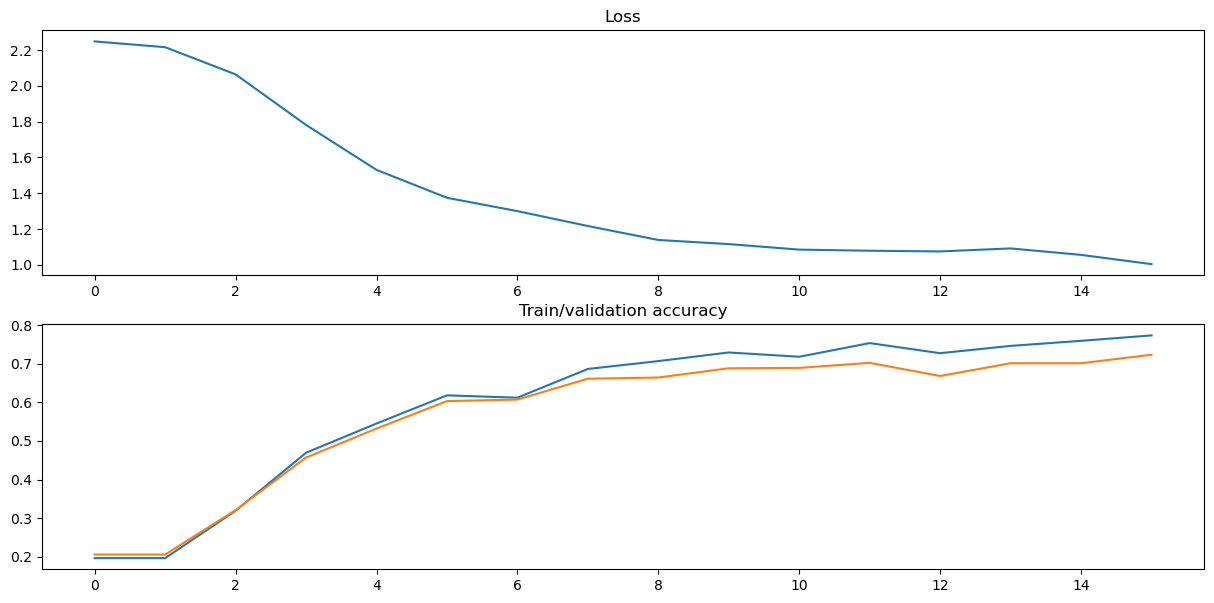

In [17]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [19]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.674000
